In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import import_ipynb
import DataLoader_P_speed
import utils
import time
import numpy as np

importing Jupyter notebook from DataLoader_P_speed.ipynb
importing Jupyter notebook from utils.ipynb


In [2]:
class args():
    def __init__(self):
        self.base_out_features = 2048
        self.t_obs = 8
        self.batch_size = 20
        self.scene_shape = [3, 144, 256]
        self.base_shape = [2048, 9, 16]
        self.hidden_size = 128
        self.embedding_size = 64
        self.input_size = 2
        self.output_size = 2
        self.sample = True
        self.n_train_sequences = 15000
        self.n_val_sequences = 10
        self.trainOrVal = 'train'
        self.citywalks = False
        
        #dataset
        self.jaad_dataset = '../../../../data/smailait-data/jaad/annotations'
        self.dtype = 'train'
        self.from_file = True
        self.file = '/data/smailait-data/train_speed.csv'
        self.val_file = '/data/smailait-data/val_speed.csv'
        self.seq_len = 4
        self.predicted_seq_len = 4
        self.crop = 0.3
        self.activity_h = 9
        self.activity_w = 16
        self.truncate = 0
        self.final_frame_offset = 0
        self.loader_workers = 20
        self.loader_shuffle = True
        self.pin_memory = False
        self.image_resize = [144, 256]
        self.image_size = [1080, 1920]
        self.device='cuda'
        
args = args()

In [3]:
class MLP_speed(nn.Module):
    def __init__(self):
        super(MLP_speed, self).__init__()
        
        self.in_ = nn.Linear(in_features=4, out_features=128)
        self.hid1 = nn.Linear(in_features=128, out_features=256)
        self.hid2 = nn.Linear(in_features=256, out_features=128)
        self.out_ = nn.Linear(in_features=128, out_features=4)
        self.activation = nn.Hardtanh(min_val=-100, max_val=100)
        
    def forward(self, input_):
        input_ = self.activation(self.in_(input_))
        input_ = self.activation(self.hid1(input_))
        input_ = self.activation(self.hid2(input_))
        output = self.activation(self.out_(input_))
        return output

In [4]:
net_speed = MLP_speed().to('cuda')

In [5]:
train, val, test = DataLoader_P_speed.data_loader(args)

frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
train  loaded
frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
train  loaded
frame
crossing_true
imagefolderpath
scenefolderpath
filename
file
bounding_box
im_size
future_bounding_box
val  loaded


In [6]:
learning_rate = 0.001
optimizer = optim.Adam(net_speed.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, threshold = 1e-8, verbose=True)
criterion = nn.MSELoss()
train_scores = []
val_scores = []

In [7]:
for epoch in range(100):
    avg_epoch_train_loss = 0
    avg_epoch_val_loss = 0
    ade = 0
    fde = 0
    aae = 0
    counter = 0
    for idx, (obs, target, obs_p, target_p) in enumerate(train):
        counter += 1
        obs = obs.type(torch.float32).to(device='cuda')
        target = target.type(torch.float32).to(device='cuda')
        
        net_speed.zero_grad()
        preds = net_speed(obs)
        train_loss = criterion(preds, target)
        train_loss.backward()
        optimizer.step()
        
        avg_epoch_train_loss += float(train_loss)
        
    avg_epoch_train_loss/=counter
    train_scores.append(avg_epoch_train_loss)

    print('e:', epoch, ' | train_loss: %.4f'% avg_epoch_train_loss, ' | val_loss: %.4f'% avg_epoch_val_loss)

e: 0  | train_loss: 19.0168  | val_loss: 0.0000
e: 1  | train_loss: 18.7104  | val_loss: 0.0000
e: 2  | train_loss: 18.5375  | val_loss: 0.0000
e: 3  | train_loss: 18.5910  | val_loss: 0.0000
e: 4  | train_loss: 18.5819  | val_loss: 0.0000
e: 5  | train_loss: 18.4533  | val_loss: 0.0000
e: 6  | train_loss: 18.4561  | val_loss: 0.0000
e: 7  | train_loss: 18.4120  | val_loss: 0.0000
e: 8  | train_loss: 18.4005  | val_loss: 0.0000
e: 9  | train_loss: 18.2366  | val_loss: 0.0000
e: 10  | train_loss: 18.1797  | val_loss: 0.0000
e: 11  | train_loss: 18.1501  | val_loss: 0.0000
e: 12  | train_loss: 18.1225  | val_loss: 0.0000
e: 13  | train_loss: 18.1118  | val_loss: 0.0000
e: 14  | train_loss: 18.1503  | val_loss: 0.0000
e: 15  | train_loss: 18.1407  | val_loss: 0.0000
e: 16  | train_loss: 18.0924  | val_loss: 0.0000
e: 17  | train_loss: 18.1244  | val_loss: 0.0000
e: 18  | train_loss: 18.1023  | val_loss: 0.0000
e: 19  | train_loss: 18.1190  | val_loss: 0.0000
e: 20  | train_loss: 18.1094  

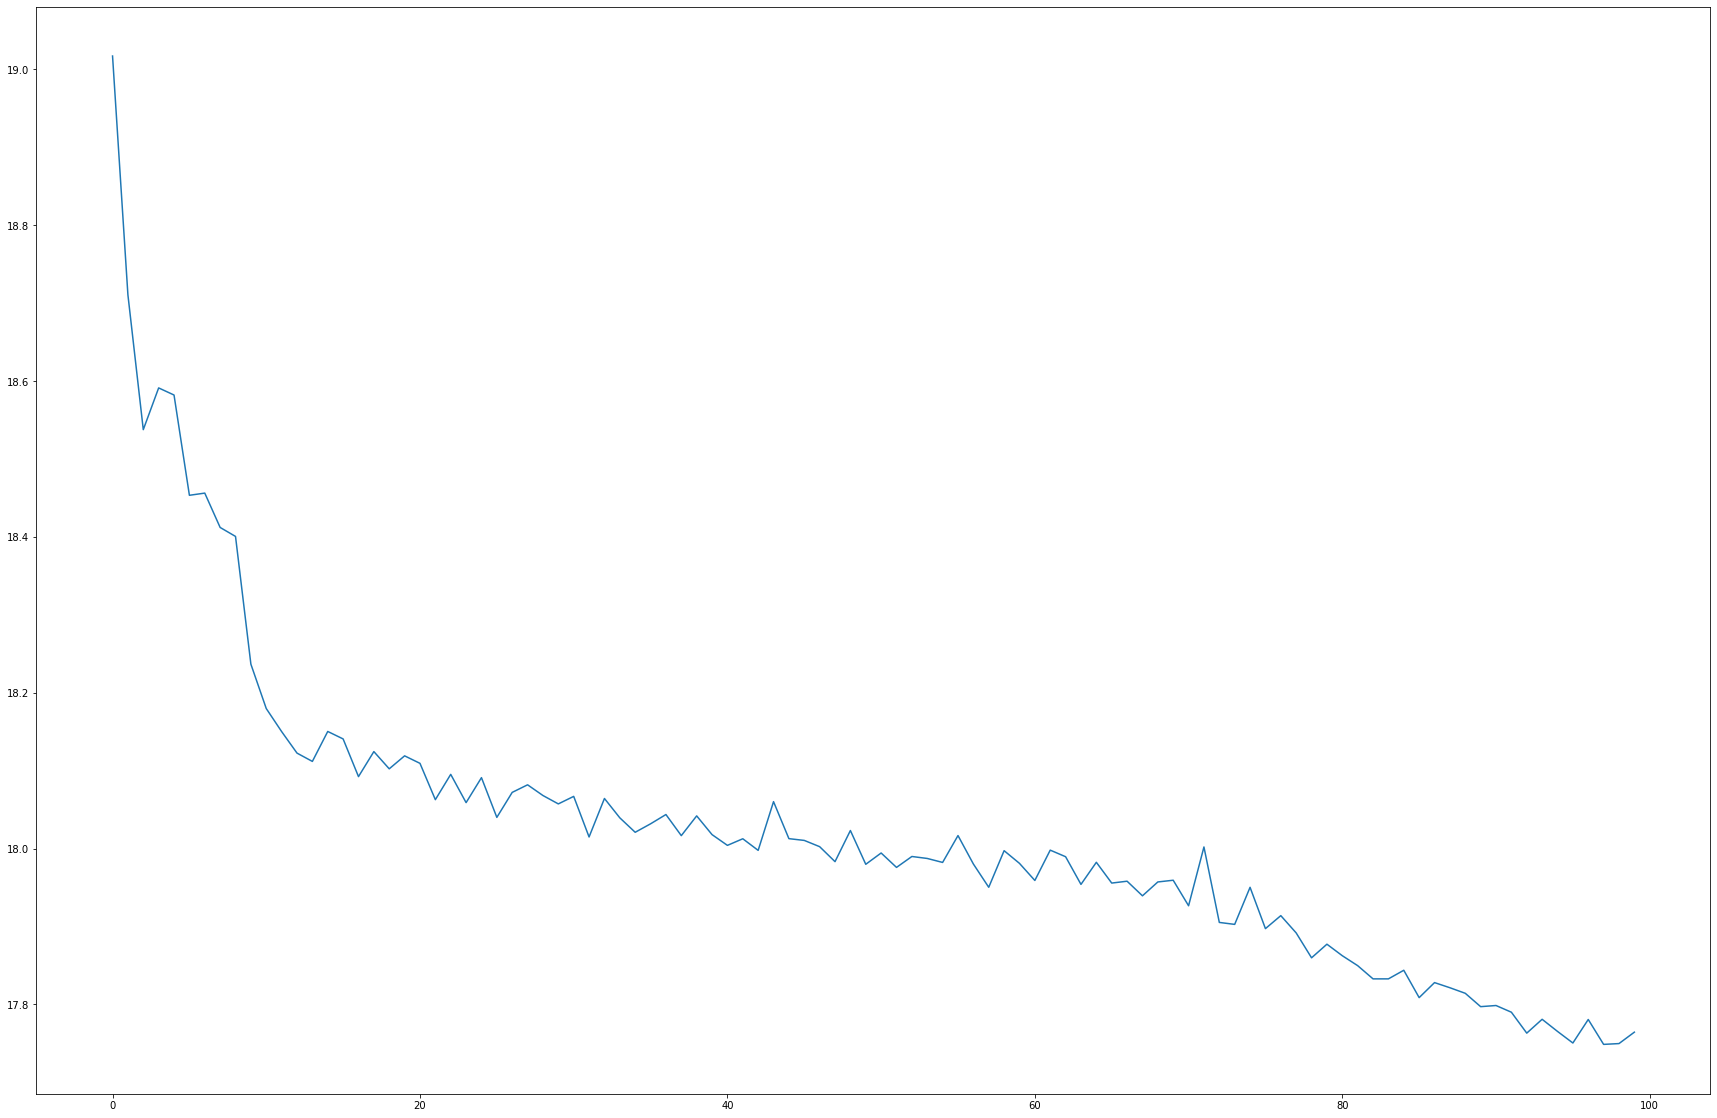

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.plot(list(range(len(train_scores))), train_scores)
plt.plot(list(range(len(val_scores))), val_scores)
plt.show()

In [9]:
avg_epoch_val_loss = 0
ade = 0
fde = 0
aiou = 0
fiou = 0
counter=0
for idx, (obs, target, obs_p, target_p) in enumerate(test):
    counter+=1
    obs = obs.type(torch.float32).to(device='cuda')
    target = target.type(torch.float32).to(device='cuda')

    with torch.no_grad():
        preds = net_speed(obs)
        val_loss = criterion(preds, target)
        preds_p = utils.speed2pos(preds, obs_p.to('cuda'), 20, 'cuda')
        ade += float(utils.ADE_c(preds_p, target_p[:,:-1,:].to('cuda')))
        fde += float(utils.FDE_c(preds_p, target_p[:,:-1,:].to('cuda')))
        aiou += float(utils.AIOU(preds_p, target_p[:,:-1,:].to('cuda')))
        fiou += float(utils.FIOU(preds_p, target_p[:,:-1,:].to('cuda')))

    avg_epoch_val_loss += float(val_loss)

avg_epoch_val_loss/=counter
ade/=counter
fde/=counter     
aiou/=counter
fiou/=counter
print('val_loss: %.4f'% avg_epoch_val_loss, '| ade: %.4f'% ade, '| fde: %.4f'% fde, '| aiou: %.4f'% aiou, '| fiou: %.4f'% fiou)

val_loss: 23.3722 | ade: 11.6939 | fde: 18.5978 | aiou: 0.6930 | fiou: 0.5813
